In [10]:
import os, sys, pickle

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

import jp_mpl as jplot
import random
from copy import deepcopy
from scipy import interpolate

# My tools
import jp_analysis as analysis
reload(analysis)

from scipy import optimize
import reflection_fit
reload(reflection_fit)

<module 'reflection_fit' from '/home/jpyanez/snoplus/snoplus_python/reflection_fit.pyc'>

## Only doing the "peak" fit - see Reflection_fit_analysis to know why 

In [2]:
pmt_info = pickle.load(open('/home/jpyanez/snoplus/snoplus_python/pmt_positions.pckl'))

c = 0.299792458*1000 # mm/ns, same as in Geant4

In [3]:
# Settings
#myinput = '/home/jpyanez/scratch/laserball/337/p300_n300_0'
indir = '/home/jpyanez/scratch/SOC_files_reflections'
file_list = [x for x in os.listdir(indir) if 'pckl' in x]

In [4]:
# Get the run numbers
runs = []
for one_file in file_list:
    # These runs are way too off-axis
    if '102570' in one_file or '102572' in one_file:
        continue
    runs.append(int(one_file.split('_')[1]))
runs = np.array(runs)
runs = np.unique(runs)
print runs

[ 17375 100556 100558 101427 101428 101432 101433 102518 102529 102552
 102554 102574]


In [5]:
wavelengths = 1.*np.array([505,420,420,420,420,420,420,420,420,337,395,420])
for i in range(len(runs)):
    print runs[i], wavelengths[i]

17375 505.0
100556 420.0
100558 420.0
101427 420.0
101428 420.0
101432 420.0
101433 420.0
102518 420.0
102529 420.0
102552 337.0
102554 395.0
102574 420.0


In [6]:
non_bottom = (pmt_info['xyz'][:,2]>-6000)*(pmt_info['xyz'][:,2]<6000)


In [12]:
# Optics DB water
wl = np.array([200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0, 260.0, 265.0, 270.0, 275.0, 280.0, 285.0, 290.0, 295.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0, 335.0, 340.0, 345.0, 350.0, 355.0, 360.0, 365.0, 370.0, 375.0, 380.0, 385.0, 390.0, 395.0, 400.0, 405.0, 410.0, 415.0, 420.0, 425.0, 430.0, 435.0, 440.0, 445.0, 450.0, 455.0, 460.0, 465.0, 470.0, 475.0, 480.0, 485.0, 490.0, 495.0, 500.0, 505.0, 510.0, 515.0, 520.0, 525.0, 530.0, 535.0, 540.0, 545.0, 550.0, 555.0, 560.0, 565.0, 570.0, 575.0, 580.0, 585.0, 590.0, 595.0, 600.0, 605.0, 610.0, 615.0, 620.0, 625.0, 630.0, 635.0, 640.0, 645.0, 650.0, 655.0, 660.0, 665.0, 670.0, 675.0, 680.0, 685.0, 690.0, 695.0, 700.0, 705.0, 710.0, 715.0, 720.0, 725.0, 730.0, 735.0, 740.0, 745.0, 750.0, 755.0, 760.0, 765.0, 770.0, 775.0, 780.0, 785.0, 790.0, 795.0, 800.0, ])
gvel = np.array([182.709, 185.104, 187.309, 189.341, 191.217, 192.951, 194.558, 196.047, 197.432, 198.72, 199.92, 201.04, 202.088, 203.068, 203.986, 204.849, 205.659, 206.422, 207.14, 207.818, 208.458, 209.063, 209.636, 210.179, 210.694, 211.183, 211.648, 212.09, 212.51, 212.911, 213.294, 213.659, 214.008, 214.342, 214.661, 214.967, 215.26, 215.541, 215.81, 216.069, 216.318, 216.557, 216.787, 217.008, 217.222, 217.427, 217.626, 217.817, 218.001, 218.18, 218.352, 218.518, 218.679, 218.835, 218.986, 219.132, 219.274, 219.411, 219.544, 219.673, 219.798, 219.92, 220.038, 220.153, 220.264, 220.372, 220.478, 220.58, 220.68, 220.777, 220.872, 220.964, 221.054, 221.141, 221.226, 221.31, 221.391, 221.47, 221.547, 221.622, 221.696, 221.768, 221.838, 221.907, 221.974, 222.039, 222.104, 222.166, 222.228, 222.288, 222.346, 222.404, 222.46, 222.515, 222.569, 222.622, 222.674, 222.725, 222.775, 222.824, 222.871, 222.918, 222.964, 223.01, 223.054, 223.097, 223.14, 223.182, 223.223, 223.264, 223.303, 223.342, 223.381, 223.418, 223.455, 223.491, 223.527, 223.562, 223.597, 223.631, 223.664,])
group_vel_fcn = interpolate.InterpolatedUnivariateSpline(wl, gvel)

In [16]:
c/group_vel_fcn(420.)

1.3801201443684339

In [8]:
manip    = []
soc_fit  = []
refl_fit = []
occupancy = []
residual  = []
npmts = []

refl_width = 4.5


for one_run in runs:
    print '\nRun ', one_run
    this_file_list = [x for x in file_list if "%i" % one_run in x]
    
    shadowed= pickle.load(open('/home/jpyanez/scratch/SOC_shadows/SOC_' + "%010d" % one_run + '.pckl'))
    pmtbool = ((pmt_info['type'] == 1)+(pmt_info['type'] == 7))*non_bottom * ~shadowed
    
    # Open infiles, load and sum the histograms
    sumkeys = ['toa_map', 'occupancy']
    for iFile, fname in enumerate(this_file_list):
        fopen     = open(os.path.join(indir, fname))
        this_data = pickle.load(fopen)
        if iFile == 0:
            data = deepcopy(this_data)
        else:
            for one_key in sumkeys:
                if this_data.has_key(one_key):
                    data[one_key] += this_data[one_key]
                else:
                    print fname, ' has no ', one_key
        fopen.close()

    toa_peak = np.zeros([pmt_info['type'].size, 4])
    for iPMT in range(toa_peak.shape[0]):
        toa_peak[iPMT,:] = reflection_fit.getGausTimes( n = data['toa_map'][iPMT,:],
                                                        expected_tdelay = 76.,
                                                        refl_peak_width = refl_width,
                                                        ybins = data['time_edges'] )
        
    peakbool= (toa_peak[:,0] > 0) * (toa_peak[:,2]>0)
    peak_tdiff  = toa_peak[:,2] - toa_peak[:,0]
    peak_err  = dpeak_err = np.ones_like(peak_tdiff)
    
    
    peakfit = reflection_fit.FitLBpos( data = peak_tdiff,
                                       error = peak_err,
                                       pmt_xyz = pmt_info['xyz'],
                                       pmtbool = peakbool*pmtbool,
                                       print_call = False)
    
    occupancy.append(data['occupancy'][peakfit.pmtbool].mean())
    manip.append(data['manip_pos'])
    soc_fit.append(data['soc_fit'])
    

    
    wrapfcn = lambda p: peakfit(*p)
    fit_counter = 0
    repeat_fit = True
    while repeat_fit:
        my_x0 = np.concatenate((data['manip_pos']*(1+np.random.rand(3)/3.) + np.random.rand(3)/20., [1.3]))
        peakr = optimize.minimize(wrapfcn,
                            x0 = my_x0,
                            method = 'SLSQP',
                            bounds=((-6500,6500),
                                    (-6500,6500),
                                    (-6500,6500),
                                    (0.5, 2.)),
                            options={'ftol':1E-7, 'maxiter':1000})
        fit_counter += 1
        if peakr.success:
            repeat_fit = False
            print 'PEAK good fit at ', fit_counter
        if fit_counter >= 20:
            print 'PEAK Fit failed! Check why'
            repeat_fit = False
    refl_fit.append(peakr.x)
    residual.append(peakr.fun)
    npmts.append(np.sum(peakfit.pmtbool))
    
    print 'Mean occupancy', occupancy[-1]
    print manip[-1]
    print soc_fit[-1]
    print refl_fit[-1]


Run  17375


KeyboardInterrupt: 

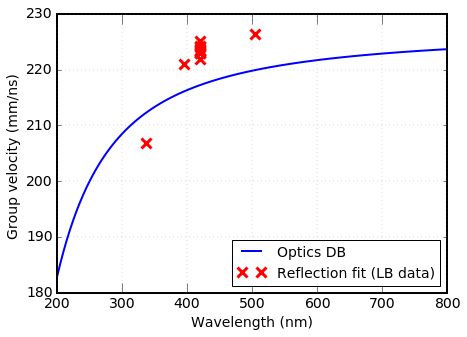

In [142]:
plt.figure(figsize=(7,5))
plt.plot(wl, gvel, label = 'Optics DB')
#plt.plot(wl, gvel*1.02, '--', label = '1.02*Optics DB')

plt.plot(wavelengths, c/np.array([x[3] for x in refl_fit]), 'xr', 
         markersize=10, markeredgewidth=3, label='Reflection fit (LB data)')
plt.ylabel('Group velocity (mm/ns) ')
plt.xlabel('Wavelength (nm)')
plt.legend(loc=0, fontsize=14)

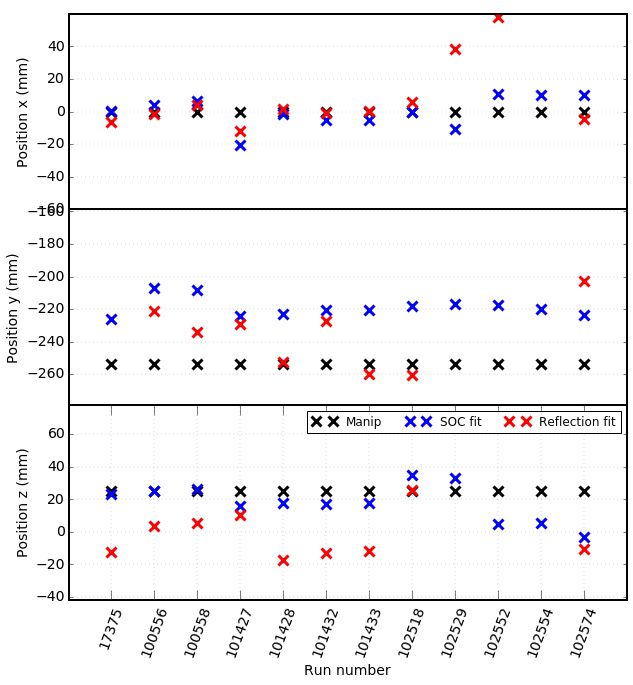

In [143]:
dimlabels = ['x', 'y', 'z']
fig = plt.figure(figsize=(10,3.5*3.))
axes = []

for dim in range(3):
    axes.append(fig.add_subplot(3,1,dim+1))
    this_manip = np.array([x[dim] for x in soc_fit])

    plt.plot(range(len(runs)), [x[dim] for x in manip], 'xk',
             markersize=10, markeredgewidth=3, label='Manip')
    plt.plot(range(len(runs)), [x[dim] for x in soc_fit], 'xb',
             markersize=10, markeredgewidth=3, label = 'SOC fit')
    plt.plot(range(len(runs)), [x[dim] for x in refl_fit], 'xr',
             markersize=10, markeredgewidth=3, label ='Reflection fit')
    plt.ylim([this_manip.mean()-60, this_manip.mean()+60])
    plt.xlim([-1, len(runs)])
    plt.ylabel('Position ' + dimlabels[dim] + ' (mm)')
    axes[-1].set_xticks([])

plt.legend(loc=0,ncol=3)
plt.xlabel('Run number')
axes[-1].set_xticks(range(0, len(runs)))
axes[-1].set_xticklabels(["%i" % x for x in runs], rotation=70)
plt.subplots_adjust(hspace=0.)

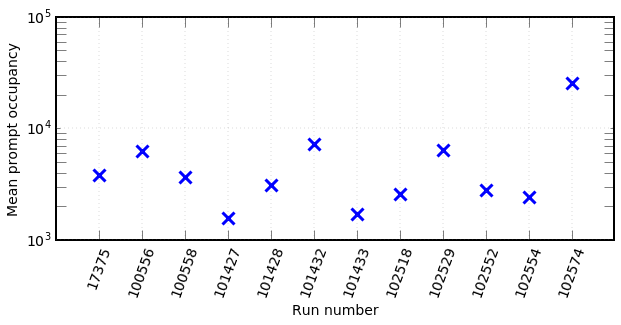

In [144]:
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(111)
plt.plot(range(0, len(runs)), occupancy, 'x', markersize=12, markeredgewidth=3)
axes.set_xticks(range(0, len(runs)))
axes.set_xticklabels(["%i" % x for x in runs], rotation=70)
plt.xlim([-1, len(runs)])
plt.yscale('log')
plt.ylabel('Mean prompt occupancy')
plt.xlabel('Run number')


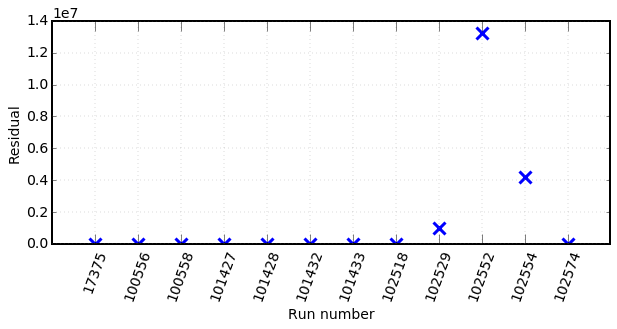

In [145]:
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(111)
plt.plot(range(0, len(runs)), residual, 'x', markersize=12, markeredgewidth=3)
axes.set_xticks(range(0, len(runs)))
axes.set_xticklabels(["%i" % x for x in runs], rotation=70)
plt.xlim([-1, len(runs)])
#plt.yscale('log')
plt.ylabel('Residual')
plt.xlabel('Run number')


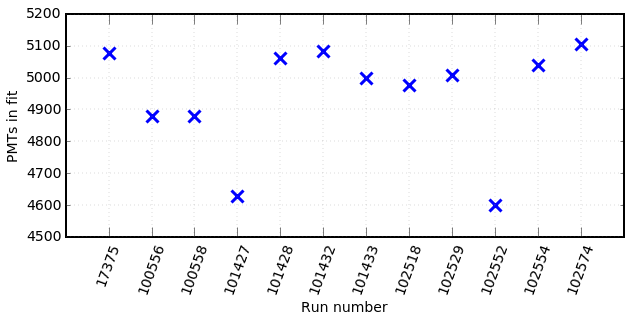

In [146]:
fig = plt.figure(figsize=(10,4))
axes = fig.add_subplot(111)
plt.plot(range(0, len(runs)), npmts, 'x', markersize=12, markeredgewidth=3)
axes.set_xticks(range(0, len(runs)))
axes.set_xticklabels(["%i" % x for x in runs], rotation=70)
plt.xlim([-1, len(runs)])
#plt.yscale('log')
plt.ylabel('PMTs in fit')
plt.xlabel('Run number')
